In [2]:
# import libraries

# Data handling
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
# sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score, classification_report


# TensorFlow
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, InputLayer
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam, SGD

# Global setting
%matplotlib inline
sns.set_style('darkgrid')
warnings.filterwarnings('ignore')

In [3]:
# Read the training and test sets
training_df = pd.read_csv("../data/preprocessed/training_set.csv")
testing_df = pd.read_csv("../data/preprocessed/testing_set.csv")

In [4]:
# Splitt the data into training and testing sets
X_train, X_test, y_train, y_test = training_df.drop('Target', axis=1),testing_df.drop('Target', axis=1), training_df['Target'],  testing_df['Target']

## Functions to help the models


In [6]:
# a list to hold all model scores to be used later
model_score_list = []

# A function to plot training and validation accuracy and loss
def plot_scores(history):
    hist = pd.DataFrame(history.history)
    plt.figure(figsize=(16, 5))
    plt.subplot(1,2,1)
    plt.title("Model_1 Training and test loss")
    plt.plot(hist['loss'], label='training_loss')
    plt.plot(hist['val_loss'], label='Test_loss')
    plt.legend()
    
    plt.subplot(1,2,2)
    plt.title("Model_1 Training and test accuracy")
    plt.plot(hist['accuracy'], label='training_accuracy')
    plt.plot(hist['val_accuracy'], label='test_accuracy')
    plt.legend()
    plt.show()


# Create a function to get scores
def get_scores(y_test, pred, model:'str'):
    """
    This functions takes the Test set, predicted values and the model name
    It them get the socres and create a dictionary for the model scores to be appended to the
    score list
    """
    # round the output from the model to get the required classes since it's binary
    pred = tf.round(pred)
    # get the scores
    acc = accuracy_score(y_test, pred)
    prec = precision_score(y_test, pred, average='weighted')
    recall = recall_score(y_test, pred, average='weighted')
    f1 = f1_score(y_test, pred,average='weighted')

    # append the scores to the list
    model_score_list.append({'Model':model, 'Accuracy':acc, 'Precision':prec, 'Recall':recall, 'F1':f1})

## Building Model 1
1. One hidden Layer with 50 Units(Neurons)
2. One output layer('Softmax activation')

In [8]:
# set random seed
tf.random.set_seed(42)

# Create a Sequential Model
model_1 = Sequential([
    InputLayer(shape=X_train.iloc[0].shape),
    Dense(50, activation='relu', name='hidden_layer'),
    Dense(1, activation='sigmoid', name='output_layer')
], name='Model_1')


# compile the model
model_1.compile(
    loss=BinaryCrossentropy(),
    optimizer=Adam(learning_rate=0.01),
    metrics=['accuracy']
)


# fit the model
history = model_1.fit(X_train, y_train, batch_size=100, epochs=100, validation_split=0.2, verbose=0)
# Get the model's summary
model_1.summary()

Model: "Model_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ hidden_layer (Dense)            │ (None, 50)             │         2,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,455 (25.22 KB)

 Trainable params: 2,151 (8.40 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 4,304 (16.82 KB)

In [9]:
# Get predictions
pred_1 = model_1.predict(X_test)

1886/1886 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step


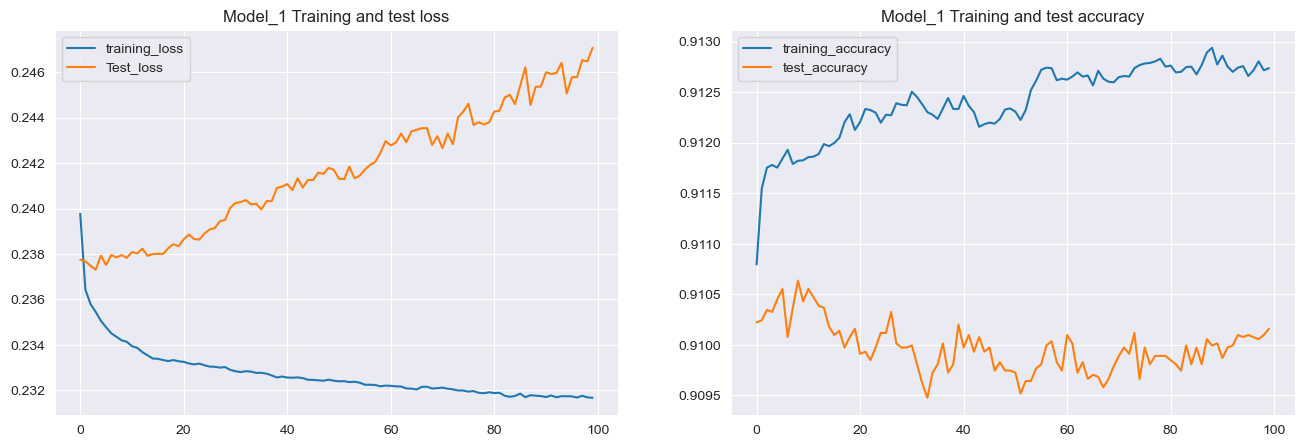

In [10]:
# let plot the model's Accuracy and loss
plot_scores(history)

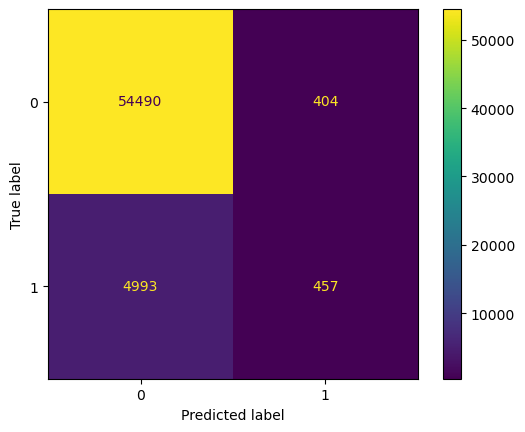

In [11]:
# Display confusion matrix
sns.reset_orig()
ConfusionMatrixDisplay.from_predictions(y_test, tf.round(pred_1))
plt.show()

In [12]:
# print the classification report
print(classification_report(y_test, tf.round(pred_1)))

              precision    recall  f1-score   support

           0       0.92      0.99      0.95     54894
           1       0.53      0.08      0.14      5450

    accuracy                           0.91     60344
   macro avg       0.72      0.54      0.55     60344
weighted avg       0.88      0.91      0.88     60344



In [13]:
# Get the model's scores and save them
get_scores(y_test, pred_1, 'model_1')

In [14]:
# saving the models for deployment
model_1.save('../Models/model_1.h5')

<b>Model_1 Evaluation</b> <br>
From the metrics, the model is performing well with an accuracy of 91%. However, when looking at the confusion matrix, it appears that due to the high class imbalance, the model has learned more from the class without heart disease, as it has more instances in the dataset. To address this issue, we will attempt to use more hidden layers and neurons to see if the model can better learn the patterns in the data.

## Building Model 2
3 hidden units
1 output layer

1. Layer one 100 units(neurons)
2. Layer two 50 units(neurons)
3. Layer three 30 units(neurons)
4. Layer 4(output) 1 unit, activation=sigmoid
5. Train the model twice the time model one took

In [17]:
# Create a random seed
tf.random.set_seed(42)

# build the model
model_2 = Sequential([
    InputLayer(shape=X_train.iloc[0].shape),
    Dense(100, activation='relu', name='hidden_layer_1'),
    Dense(50, activation='relu', name='hidden_layer_2'),
    Dense(30, activation='relu', name='hidden_layer_3'),
    Dense(1, activation='sigmoid', name='output_layer')
])

# compile the model
model_2.compile(
    loss=BinaryCrossentropy(),
    optimizer=Adam(learning_rate=0.01),
    metrics=['accuracy']
)

# fit the model on the training set
history = model_2.fit(X_train, y_train, epochs=200, verbose=0, batch_size=32, validation_split=0.2)

# get model summary
model_2.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ hidden_layer_1 (Dense)          │ (None, 100)            │         4,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer_2 (Dense)          │ (None, 50)             │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer_3 (Dense)          │ (None, 30)             │         1,530 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 1)              │            31 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,435 (126.70 KB)

 Trainable params: 10,811 (42.23 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 21,624 (84.47 KB)

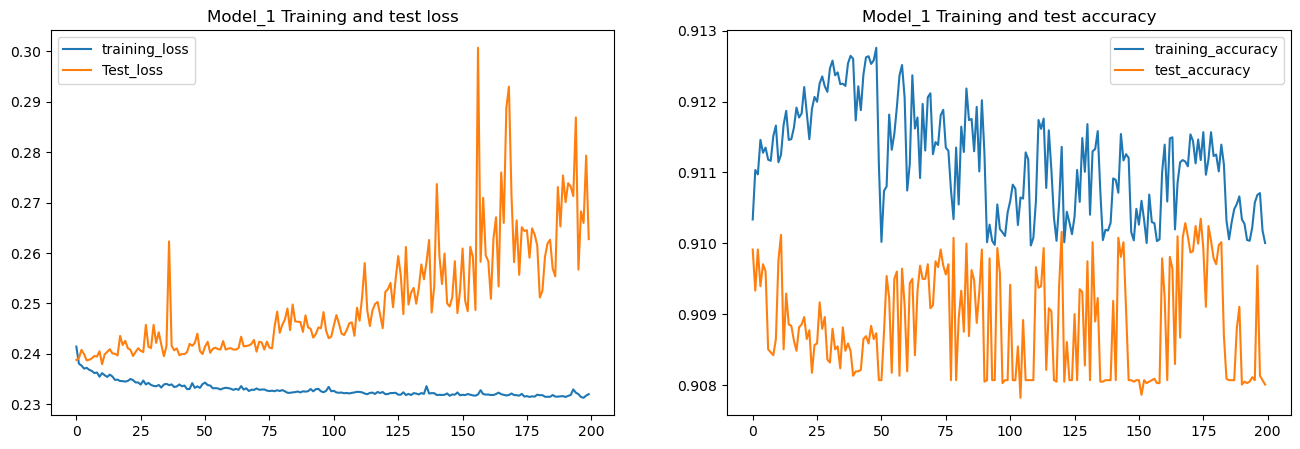

In [18]:
# let plot the model's Accuracy and loss
plot_scores(history)

In [19]:
# Make prediction with the model and draw the confusion matrix
pred_2 = model_2.predict(X_test)

1886/1886 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step


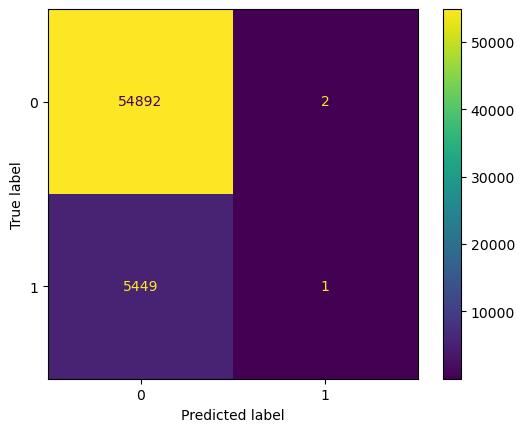

In [20]:
# get confusion matrix
sns.reset_orig()
ConfusionMatrixDisplay.from_predictions(y_test, tf.round(pred_2))
plt.show()

In [21]:
# print the classification report
print(classification_report(y_test, tf.round(pred_2)))

              precision    recall  f1-score   support

           0       0.91      1.00      0.95     54894
           1       0.33      0.00      0.00      5450

    accuracy                           0.91     60344
   macro avg       0.62      0.50      0.48     60344
weighted avg       0.86      0.91      0.87     60344



In [22]:
# Get the model's scores and save them
get_scores(y_test, pred_2, 'model_2')

In [58]:
# saving the models for deployment
model_2.save('../Models/model_2.keras')

<b> Model Evaluation</b> <br>
Based on the observations, both models are heavily focused on the majority class due to the significant class imbalance. To address this issue, we plan to employ an oversampling method to inject synthetic data into the minority class. Subsequently, we will train two new models, referred to as model 3 and model 4, on the modified dataset resulting from the oversampling process.

## Oversampling with SMOTE from Imblearn

In [25]:
# Import the smote class from imblearn
from imblearn.over_sampling import SMOTE

In [26]:
# create a new dataframe from appending both training and testing sets
med_df = pd.concat([training_df, testing_df], ignore_index=True)
med_df.sample(5)

,0,1,2,3,4,5,6,7,8,9,...,32,33,34,35,36,37,38,39,40,Target
276227,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.129905,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0
154500,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.127731,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0
104583,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.308946,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1
150552,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.207171,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0
100369,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.140167,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0


In [27]:
# Getting the data into X and y (Characterictics and target)
X = med_df.drop('Target', axis=1)
y = med_df['Target']

# check the values of target before sampling
print(f"Targets before sampling: \n{y.value_counts()}")

Targets before sampling: 
0    274456
1     27261
Name: Target, dtype: int64


In [28]:
# create an instance of SMOTE
sm =SMOTE(random_state=42)

# perform the over_sampling
X_sampled, y_sampled = sm.fit_resample(X,y)

# print the classes after oversampling
print(f"Targets after sampling: \n{y_sampled.value_counts()}")

Targets after sampling: 
0    274456
1    274456
Name: Target, dtype: int64


Now that we have balanced all classes, we will train models 1 and 2 with the newly created data, giving them new identities as model 3 and 4, respectively.

In [30]:
# split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_sampled, y_sampled, test_size=0.2, random_state=42)

## Model 3
This model will have same features as model 1

In [32]:
# set random seed
tf.random.set_seed(42)

# Create a Sequential Model
model_3 = Sequential([
    InputLayer(shape=X_train.iloc[0].shape),
    Dense(50, activation='relu', name='hidden_layer'),
    Dense(1, activation='sigmoid', name='output_layer')
], name='Model_3')


# compile the model
model_3.compile(
    loss=BinaryCrossentropy(),
    optimizer=Adam(learning_rate=0.01),
    metrics=['accuracy']
)


# fit the model
history_3 = model_3.fit(X_train, y_train, batch_size=100, epochs=100, validation_split=0.2, verbose=0)
# Get the model's summary
model_3.summary()

Model: "Model_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ hidden_layer (Dense)            │ (None, 50)             │         2,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,455 (25.22 KB)

 Trainable params: 2,151 (8.40 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 4,304 (16.82 KB)

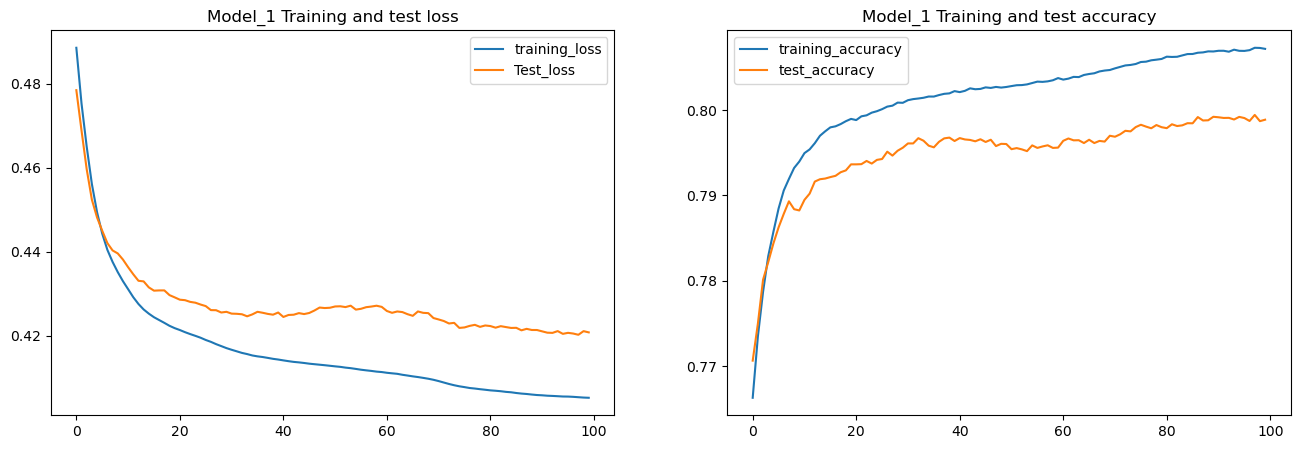

In [33]:
# let plot the model's Accuracy and loss
plot_scores(history_3)

In [34]:
# Make prediction with the model and draw the confusion matrix
pred_3 = model_3.predict(X_test)

3431/3431 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step


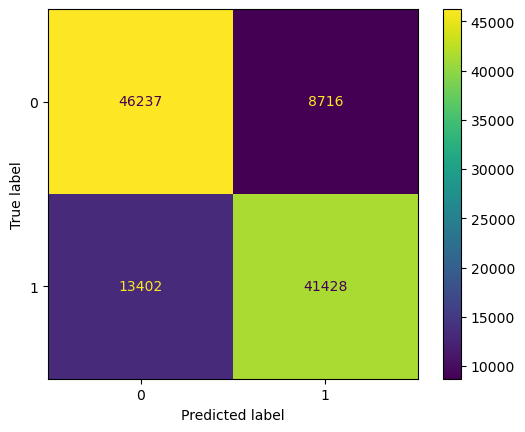

In [35]:
# get confusion matrix
sns.reset_orig()
ConfusionMatrixDisplay.from_predictions(y_test, tf.round(pred_3))
plt.show()

In [36]:
# print the classification report
print(classification_report(y_test, tf.round(pred_3)))

              precision    recall  f1-score   support

           0       0.78      0.84      0.81     54953
           1       0.83      0.76      0.79     54830

    accuracy                           0.80    109783
   macro avg       0.80      0.80      0.80    109783
weighted avg       0.80      0.80      0.80    109783



In [37]:
# Get the model's scores and save them
get_scores(y_test, pred_3, 'model_3')

In [59]:
# saving the models for deployment
model_3.save('../Models/model_3.keras')

## Model 4
This will have same characteristics as model two but will be trained and tested on the new data

In [39]:
# Create a random seed
tf.random.set_seed(42)

# build the model
model_4 = Sequential([
    InputLayer(shape=X_train.iloc[0].shape),
    Dense(100, activation='relu', name='hidden_layer_1'),
    Dense(50, activation='relu', name='hidden_layer_2'),
    Dense(30, activation='relu', name='hidden_layer_3'),
    Dense(1, activation='sigmoid', name='output_layer')
])

# compile the model
model_4.compile(
    loss=BinaryCrossentropy(),
    optimizer=Adam(learning_rate=0.01),
    metrics=['accuracy']
)

# fit the model on the training set
history_4 = model_4.fit(X_train, y_train, epochs=200, verbose=0, batch_size=32, validation_split=0.2)

# get model summary
model_4.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ hidden_layer_1 (Dense)          │ (None, 100)            │         4,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer_2 (Dense)          │ (None, 50)             │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer_3 (Dense)          │ (None, 30)             │         1,530 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 1)              │            31 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,435 (126.70 KB)

 Trainable params: 10,811 (42.23 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 21,624 (84.47 KB)

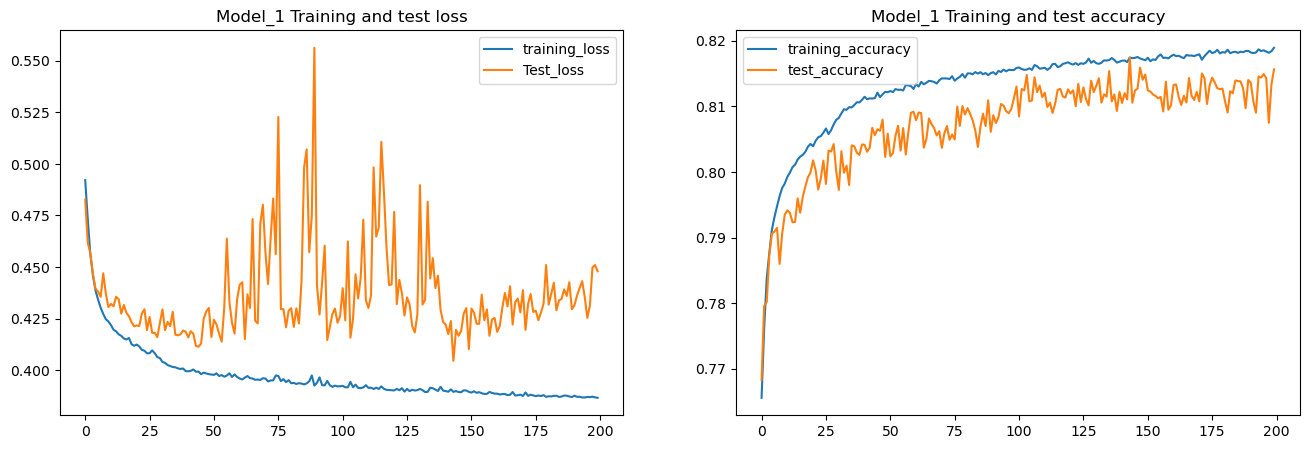

In [40]:
# let plot the model's Accuracy and loss
plot_scores(history_4)

In [41]:
# Make prediction with the model and draw the confusion matrix
pred_4 = model_4.predict(X_test)

3431/3431 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step


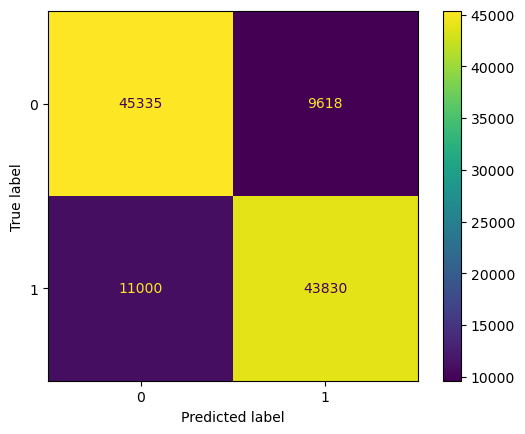

In [42]:
# get confusion matrix
sns.reset_orig()
ConfusionMatrixDisplay.from_predictions(y_test, tf.round(pred_4))
plt.show()

In [43]:
# print the classification report
print(classification_report(y_test, tf.round(pred_4)))

              precision    recall  f1-score   support

           0       0.80      0.82      0.81     54953
           1       0.82      0.80      0.81     54830

    accuracy                           0.81    109783
   macro avg       0.81      0.81      0.81    109783
weighted avg       0.81      0.81      0.81    109783



In [44]:
# Get the model's scores and save them
get_scores(y_test, pred_4, 'model_4')

In [60]:
# saving the models for deployment
model_4.save('../Models/model_4.keras')

In [45]:
# creating a dataframe for the model scores to select the best model based on recall and precision
scores_df = pd.DataFrame(model_score_list)
scores_df

,Model,Accuracy,Precision,Recall,F1
0,model_1,0.910563,0.881263,0.910563,0.879840
1,model_2,0.909668,0.857642,0.909668,0.866686
2,model_3,0.798530,0.800702,0.798530,0.798152
3,model_4,0.812193,0.812386,0.812193,0.812161
